# 03. Train Detector CNN
This notebook trains the Plate Detector model. It uses a CNN to regress the bounding box coordinates (x, y, w, h) of the license plate.

In [10]:
import pandas as pd
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [11]:
# Config
CSV_PATH = '../data/processed/train_detection.csv'
MODEL_PATH = '../models/detector_cnn.h5'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [12]:
# Load Data
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f'Loaded {len(df)} samples.')
else:
    print('CSV not found. Please run Notebook 01 first.')
    df = pd.DataFrame()

Loaded 828 samples.


In [13]:
def data_generator(df, batch_size=32, target_size=(224, 224), is_training=True):
    while True:
        if is_training:
            df = df.sample(frac=1).reset_index(drop=True)
            
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            images = []
            coords = []
            
            for _, row in batch_df.iterrows():
                img_path = row['image_path']
                if not os.path.exists(img_path):
                    continue
                    
                img = cv2.imread(img_path)
                if img is None: continue
                
                h_orig, w_orig = img.shape[:2]
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized / 255.0)
                
                # Normalize coords (0-1)
                x = row['x'] / w_orig
                y = row['y'] / h_orig
                w = row['w'] / w_orig
                h = row['h'] / h_orig
                coords.append([x, y, w, h])
                
            if len(images) == 0:
                continue
                
            yield np.array(images), np.array(coords)

In [14]:
# Split Train/Val
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(f'Train: {len(train_df)}, Val: {len(val_df)}')

Train: 745, Val: 83


In [15]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid') # Output: x, y, w, h (normalized)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\Paco\miniconda3\envs\AI\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train
if not df.empty:
    history = model.fit(
        data_generator(train_df, BATCH_SIZE, IMG_SIZE),
        steps_per_epoch=len(train_df) // BATCH_SIZE,
        validation_data=data_generator(val_df, BATCH_SIZE, IMG_SIZE),
        validation_steps=len(val_df) // BATCH_SIZE,
        epochs=EPOCHS
    )
    
    # Save
    os.makedirs('../models', exist_ok=True)
    model.save(MODEL_PATH)
    print(f'Model saved to {MODEL_PATH}')
else:
    print('No data to train.')

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - loss: 0.0580 - val_loss: 0.0259
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - loss: 0.0262 - val_loss: 0.0157
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - loss: 0.0188 - val_loss: 0.0108
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - loss: 0.0142 - val_loss: 0.0096
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - loss: 0.0118 - val_loss: 0.0079
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - loss: 0.0098 - val_loss: 0.0069
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - loss: 0.0078 - val_loss: 0.0054
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step

Model saved to ../models/detector_cnn.h5


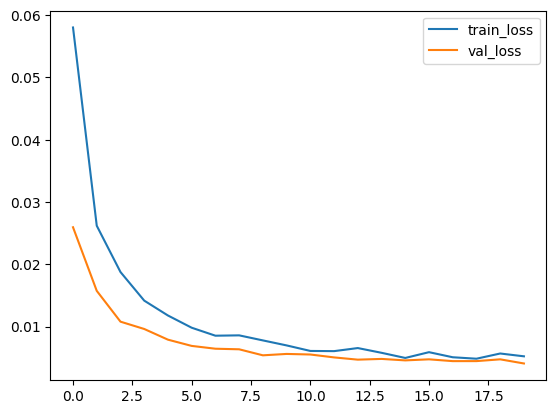

In [17]:
# Plot History
if 'history' in locals():
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()